# Redes Neuronales en Tensorflow (Parte 1) #

[Tensorflow](https://www.tensorflow.org/) es una herramienta muy poderosa para crear redes neuronales artificiales de forma fácil y eficiente.

Si nunca has estudiado los principios matemáticos de las redes neuronales artificiales, te invito a estudiar el curso [Algoritmos de Inteligencia Artificial con Redes Neuronales Artificiales](https://iranroman.github.io/algoritmica/index.html) (disponible gratuitamente en linea).

Para empezar, cargamos Tensorflow y herramientas generales de python

In [8]:
# importando las librerias de Python que vamos a necesitar
import numpy as np
import scipy.io
import tensorflow as tf
import matplotlib.pyplot as plt

In [66]:
# ahora cargemos una base de datos con la que experimentaremos
CIFAR_10 = scipy.io.loadmat('cifar_10.mat')
caracteristicas = CIFAR_10['imag']
categ_de_imagen = CIFAR_10['desc']

Aquí, la variable características es una matriz de tamaño 3000x3072. Las ileras corresponden a categorias distintas de obtejos. Las columnas de cada ilera tienen los pixeles de imágenes de objetos. Las distintas categorías son:

<ol start="0">
    <li>Aviones</li>
    <li>Automóviles</li>
    <li>Aves</li>
    <li>Gatos</li>
    <li>Venados</li>
    <li>Perros</li>
    <li>Ranas</li>
    <li>Caballos</li>
    <li>Barcos</li>
    <li>Camiones</li>
</ol>

Entonces, las primeras 300 ileras de la matriz corresponden a fotos de Aviones, las siguientes 300 ileras corresponden a fotos de Automóviles, etc.

El sigiente bloque muestra un ejemplo de estas imágenes. Cambia la variable `imag_i` para visualizar otros ejemplos.

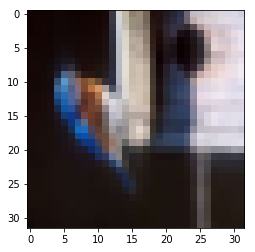

In [20]:
# visualización de ejemplos de los datos
imag_i = 601
plt.imshow(caracteristicas[imag_i,:].reshape(3,32,32).T)
plt.show()

A continuación separamos los puntos de datos en datos de entrenamiento (~80% del total), datos de validación (~10% del total), y datos de prueba (~10% del total).

In [57]:
# parámetros generales
N = caracteristicas.shape[0]
D = caracteristicas.shape[1]
C = 10 # número de clases

# generamos una variable 'data' de dimensiones 3000x3073, donde la última columna contiene 
# la categoría de la imagen de cada ilera
data = np.column_stack((caracteristicas,categ_de_imagen))

# porcentage que será usado para cada grupo de datos
perc_tr = 0.8 # entrenamiento
perc_vl = 0.1 # validación
perc_ts = 0.1 # prueba

# aleatorizando los datos
data = np.random.permutation(data)

# separando en entrenamiento, validación, y prueba
# caracteristicas
x_tr = data[:int(N*perc_tr),0:-1]
x_vl = data[int(N*perc_tr):int(N*perc_tr+N*perc_vl),0:-1]
x_ts = data[-int(N*perc_ts):,0:-1]
# categ de imagenes
y_tr = data[:int(N*perc_tr),-1].reshape(int(N*perc_tr),1)
y_vl = data[int(N*perc_tr):int(N*perc_tr+N*perc_vl),-1].reshape(int(N*perc_vl),1)
y_ts = data[-int(N*perc_ts):,-1].reshape(int(N*perc_ts),1)

# no necesitamos la variable 'data', entonces la borramos
del data

Tensorflow espera que las categorias de imagenes en los vectores `y_tr`, `y_vl`, e `y_ts` sean vectores "ones-hot", donde todos los índices son zeros, a excepción del índice de la categoría correcta, el cual tendra un 1.

El siguiente convierte los vectores `y_tr`, `y_vl`, e `y_ts` en vectores "ones-hot".

In [59]:
temp = np.zeros((y_tr.shape[0],C))
temp[np.arange(y_tr.shape[0]),y_tr.astype(int)[:,0]] = 1
y_tr = temp
temp = np.zeros((y_vl.shape[0],C))
temp[np.arange(y_vl.shape[0]),y_vl.astype(int)[:,0]] = 1
y_vl = temp
temp = np.zeros((y_ts.shape[0],C))
temp[np.arange(y_ts.shape[0]),y_ts.astype(int)[:,0]] = 1
y_ts = temp
del temp

## Construyendo una Red Neuronal Artificial con una Capa Oculta en Tensorflow ##

En este punto ya tenemos los datos listos en "arreglos numpy". Entonces ya podemos construir la Red Neuronal Artificial.

La expresión que explica el paso hacia adelante de nuestra red neuronal es:

$$\hat{y} = softmax(~\sigma(x~W^{(h)})~W^{(o)})$$

El objetivo es el de entropía cruzada:

$$J = minimize\{-log(\hat{y}_{correct})\}$$

Comenzemos por definir los parámetros que nuestra Red Neuronal necesitará:

In [62]:
# Parámetros generales
N = x_tr.shape[0] # número de puntos de datos
D = x_tr.shape[1] # dimensionalidad de los datos (número de pixeles por foto)
C = y_tr.shape[1] # número de clases

# Parametros afinables
H = 512 # número de nodos en la capa oculta
lr = 0.01 # la taza de aprendizaje
nepochs = 15

Para poder comenzar a usar Tensorflow, tendremos que inicializar "variables" e "iniciadores"

Las "variables" son las que haremos que Tensorflow aprenda usando una red neuronal artificial y una función objetivo.

¿En cual de estos dos tipos de objetos de Tensorflow pondremos nuestros datos? ¿Y los pesos de nuestra red neuronal?

El siguiente bloque prepara los objetos de Tensorflow y entrena la red neuronal.

In [63]:
# Aquí inicializamos los pesos de la red neuronal
W_h = tf.Variable(tf.random_normal((D,H), stddev = 0.01))
W_o = tf.Variable(tf.random_normal((H,C), stddev = 0.01))

# Ahora generamos los iniciadores donde pondremos nuestros datos. Por ahora no pondremos datos aún.
# Tensorflow genera una grafica que representa la estructura de nuestra red neuronal artificial, por lo
# tanto necesita inicializar el espacio donde pondrá nuestros datos.
# Le tenemos que dat el tipo de datos que tenemos ("float"), and y la estructura de la matriz de datos
X = tf.placeholder("float", shape=[None,D])
y = tf.placeholder("float", shape=[None,C])

# Ahora le indicamos como es el paso hacia adelante de nuestra red neuronal
h = tf.nn.sigmoid(tf.matmul(X,W_h))
scores = tf.matmul(h, W_o)

# En este punto tenemos los valores de las distintas categorias, 
# y ahora los podemos convertir en probabilidades usando softmax
y_hat = tf.nn.softmax(scores)
# También vemos cual es el indice que obtuvo la probabilidad más grande
max_y_index = tf.argmax(y_hat, axis = 1)

# El siguiente paso es calcular el objetivo de la entropía cruzada
J = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=scores))

# Ahora calculamos la derivada de el objetivo J respecto a los parámetros W. 
# Esto es exageradamente fácil en Tensorflow:
GD_step = tf.train.GradientDescentOptimizer(lr).minimize(J)

# los pasos de arriba estructuran la gráfica de Tensorflow donde vive nuestra red neuronal.
# Pero para hacer la red neuronal aprender, tenemos que empezar una sesión de tensorflow con todas las variables.
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

# Ahora le pedimos a tensorflow que corra nuestros datos por la gráfica.
# Los datos deben entrar en la gráfica de tensorflow como un argumento llamado feed_dict

# Si quiero obtener la pérdida o el objetivo antes de entrenar la red neuronal, entonces escribo:
loss = sess.run(J, feed_dict={X: x_tr, y: y_tr})
print "La pérdida inicial es: ", loss

# Si queremos entrenar la red neuronal artificial con todos los datos de entrenamiento:
sess.run(GD_step, feed_dict={X: x_tr, y: y_tr})

# Podemos usar un ciclo para entrenar más de una vez
for i in range(nepochs):
    sess.run(GD_step, feed_dict={X: x_tr, y: y_tr})

# Para ver la presición de la red neuronal artificial con los datos de entrenamiento
predicted_labels = sess.run(max_y_index, feed_dict={X: x_tr, y: y_tr})
tr_acc = np.mean(predicted_labels == np.argmax(y_tr, axis = 1))
loss = sess.run(J, feed_dict={X: x_tr, y: y_tr})
print "La pérdida al final de las épocas con los datos de entrenamiento es: ", loss
print "La presición final con los datos de entrenamiento es : ", tr_acc

# If you want to obtain the accuracy of the network on the validation set:
predicted_labels = sess.run(max_y_index, feed_dict={X: x_vl, y: y_vl})
vl_acc = np.mean(predicted_labels == np.argmax(y_vl, axis = 1))
print "La presición final con los datos de validación es : ", vl_acc
                 
sess.close()                 

La pérdida inicial es:  2.30682
La pérdida al final de las épocas con los datos de entrenamiento es:  2.21205
La presición final con los datos de entrenamiento es :  0.290833333333
La presición final con los datos de validación es :  0.243333333333


Esta red neuronal se puede mejorar de la siguiente manera:

1. Agregando sesgos además de pesos (¿por qué ayudaría esto?)

$$\hat{y} = softmax(~\sigma(x~W^{(h)} + b^{(h)})~W^{(o)} + b^{(o)})$$

2. No mostrándole todos los datos a la red neuronal, pero en lugar de eso generando "mini-montones" de datos.

3. ¿De qué otras maneras crees que podría ser mejorada la red neuronal?

El siguiente bloque implementa los primeros dos puntos arriba.

In [65]:
# Aquí inicializamos los pesos de la red neuronal y los sesgos
W_h = tf.Variable(tf.random_normal((D,H), stddev = 0.01)) # mean=0.0
b_h = tf.Variable(tf.zeros((1,H)))
W_o = tf.Variable(tf.random_normal((H,C), stddev = 0.01)) # mean=0.0
b_o = tf.Variable(tf.zeros((1,C)))

# Ahora generamos los iniciadores donde pondremos nuestros datos. Por ahora no pondremos datos aún.
# Tensorflow genera una grafica que representa la estructura de nuestra red neuronal artificial, por lo
# tanto necesita inicializar el espacio donde pondrá nuestros datos.
# Le tenemos que dat el tipo de datos que tenemos ("float"), and y la estructura de la matriz de datos
X = tf.placeholder("float", shape=[None,D])
y = tf.placeholder("float", shape=[None,C])

# forward pass
h = tf.nn.sigmoid(tf.matmul(X,W_h) + b_h)
scores = tf.matmul(h, W_o) + b_o

# softmax para obtener probabilidades
y_hat = tf.nn.softmax(scores)
# ¿Cuales indices tienen las probabilidades más altas?
max_y_index = tf.argmax(y_hat, axis = 1)

# Calculamos la pérdida u objetivo
J = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=scores))
# Calculamos la derivada de J respecto a los pesos de la red neuronal
GD_step = tf.train.GradientDescentOptimizer(lr).minimize(J)

# iniciamos las variables y la sesión
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

# you can loop over this to train over more than one epoch.
nepochs = 100 # número de epocas
batch_size = 24 # tamaño de los mini-montones
n_batches = x_tr.shape[0]/batch_size # número de montones
for i in xrange(nepochs):
    
    # aleatorizando los datos
    all_tr = np.concatenate((x_tr,y_tr) ,axis=1)
    np.random.permutation(all_tr)
    x_tr = all_tr[:,0:-C]
    y_tr = all_tr[:,-C:]

    # organizando los mini-montones
    x_tr_batches = x_tr.reshape(n_batches,batch_size,D)
    y_tr_batches = y_tr.reshape(n_batches,batch_size,C)    
    
    # Descenso por Gradiente con mini-montones
    for b in xrange(n_batches):
        sess.run(GD_step, feed_dict={X: x_tr_batches[b], y: y_tr_batches[b]})

# Para ver la presición de la red neuronal artificial con los datos de entrenamiento
predicted_labels = sess.run(max_y_index, feed_dict={X: x_tr, y: y_tr})
tr_acc = np.mean(predicted_labels == np.argmax(y_tr, axis = 1))
loss = sess.run(J, feed_dict={X: x_tr, y: y_tr})
print "La pérdida al final de las épocas con los datos de entrenamiento es: ", loss
print "La presición final con los datos de entrenamiento es : ", tr_acc

# If you want to obtain the accuracy of the network on the validation set:
predicted_labels = sess.run(max_y_index, feed_dict={X: x_vl, y: y_vl})
vl_acc = np.mean(predicted_labels == np.argmax(y_vl, axis = 1))
print "La presición final con los datos de validación es : ", vl_acc
                 
sess.close()             

La pérdida al final de las épocas con los datos de entrenamiento es:  2.28133
La presición final con los datos de entrenamiento es :  0.156666666667
La presición final con los datos de validación es :  0.13


---

## Construyendo el algoritmo word2vec en Tensorflow ##

El algoritmo word2vec tiene como objetivo convertir palabras de un diccionario en vectores de características que las representan. Para estudiar este algoritmo necesitaremos las siguientes librerias:

In [70]:
import tensorflow as tf
import re
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt

El siguiente bloque importa los datos y los procesa por ti. Al final tendremos un "string" con todos los datos.

In [116]:
df = pd.read_csv('songdata.csv')
df['text'] = 'trats ' + df['text'] + ' dne' # símbolos para el inicio ("trats") y final ("dne") de las canciones
data = df['text'].str.cat(sep=' ').lower() # convertir todo a minúsculas
data = ' '.join(word.strip(string.punctuation) for word in data.split()) # removiendo signos de puntuación

El siguiente bloque cuenta cuantas palabras distintas hay y les asigna un integro positivo único a cada palabra.

In [117]:
from collections import Counter
counts = Counter(data[1:5000].split(' ')) # usamos solo las primeras 10,000 palabras y las separamos
count_pairs = sorted(counts.items(), key=lambda x: (-x[1], x[0])) # las acomodamos por su taza de incidencia en las canciones
words, word_count = list(zip(*count_pairs))
word_to_id = dict(zip(words, range(len(words)))) # diccionario para convertir palabras a integros positivos
id_to_word = dict(zip(range(len(words)), words)) # diccionario para convertir integros positivos a palabras

Ahora convertimos la letra de las canciones en integros positivos y ponemos todo en un vector

In [118]:
all_data_word = data[1:5000].split(' ') # usamos solo las primeras 10,000 palabras y las separamos
all_data_id = [word_to_id[word] for word in all_data_word]

Ahora generamos una matriz con tamaño (`C+1` x `N-2`), donde `C` es el número de palabras distintas que entrenaremos a la red neuronal a ver al rededor de cada palabra, y donde `N` es el número de puntos de datos (palabras en total) que tenemos.

In [119]:
C = 2
N = len(all_data_id)
train_data = np.zeros((C+1,N-2))
j=0
for i in xrange(1,N-1):
    train_data[:,j] = all_data_id[i-C/2:i+C/2+1]
    j += 1

Ahora convertimos esto en la matriz de ceros y unos que la Red Neuronal Artificial espera:

In [120]:
V = len(word_to_id)
x_tr = np.zeros((N-2,V))
x_tr[range(N-2),train_data[1,:].astype(int)] = 1

y_tr = np.zeros((N-2,V)).astype(int)
y_tr[range(N-2),train_data[0,:].astype(int)] = 1
y_tr[range(N-2),train_data[2,:].astype(int)] = 1

Ahora si estamos listos para crear y entrenar la red neuronal

In [145]:
V = len(word_to_id)
H = 2
lr = 0.1

# inicializamos los pesos y cesgos de nuestra red neuronal
W_h = tf.Variable(tf.random_normal((V,H), stddev = 0.01)) # mean=0.0
b_h = tf.Variable(tf.zeros((1,H)))
W_o = tf.Variable(tf.random_normal((H,V), stddev = 0.01)) # mean=0.0
b_o = tf.Variable(tf.zeros((1,V)))

# generamos los iniciadores para nuestros datos
X = tf.placeholder("float", shape=[None,V])
y = tf.placeholder("int32", shape=[None,V])

# forward pass
h = tf.matmul(X,W_h) + b_h
scores = tf.matmul(h, W_o) + b_o

# softmax
y_hat = tf.nn.softmax(scores)

# calcular la pérdida
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=scores))

# backward pass
GD_step = tf.train.GradientDescentOptimizer(lr).minimize(loss)

# iniciamos la sesión y las variables
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

# Precisión final de la red neuronal 
final_loss = sess.run(loss, feed_dict={X: x_tr, y: y_tr})
print "Pérdida al final del entrenamiento: ", final_loss

# iteramos para mostrar los datos a la red neuronal artifical más de una vez
nepochs = 400
for i in xrange(nepochs):
    
    # Descenso por Gradiente
    sess.run(GD_step, feed_dict={X: x_tr, y: y_tr})

# Precisión final de la red neuronal 
final_loss = sess.run(loss, feed_dict={X: x_tr, y: y_tr})
print "Pérdida al final del entrenamiento: ", final_loss

# guardamos W_h para visualizar las características de los datos
W_h = W_h.eval(session=sess)

sess.close()              

Pérdida al final del entrenamiento:  10.7646
Pérdida al final del entrenamiento:  9.8384


El siguiente bloque visualiza las relaciones entre palabras en base a las características que la red neuronal artificial aprendió.

<IPython.core.display.Javascript object>


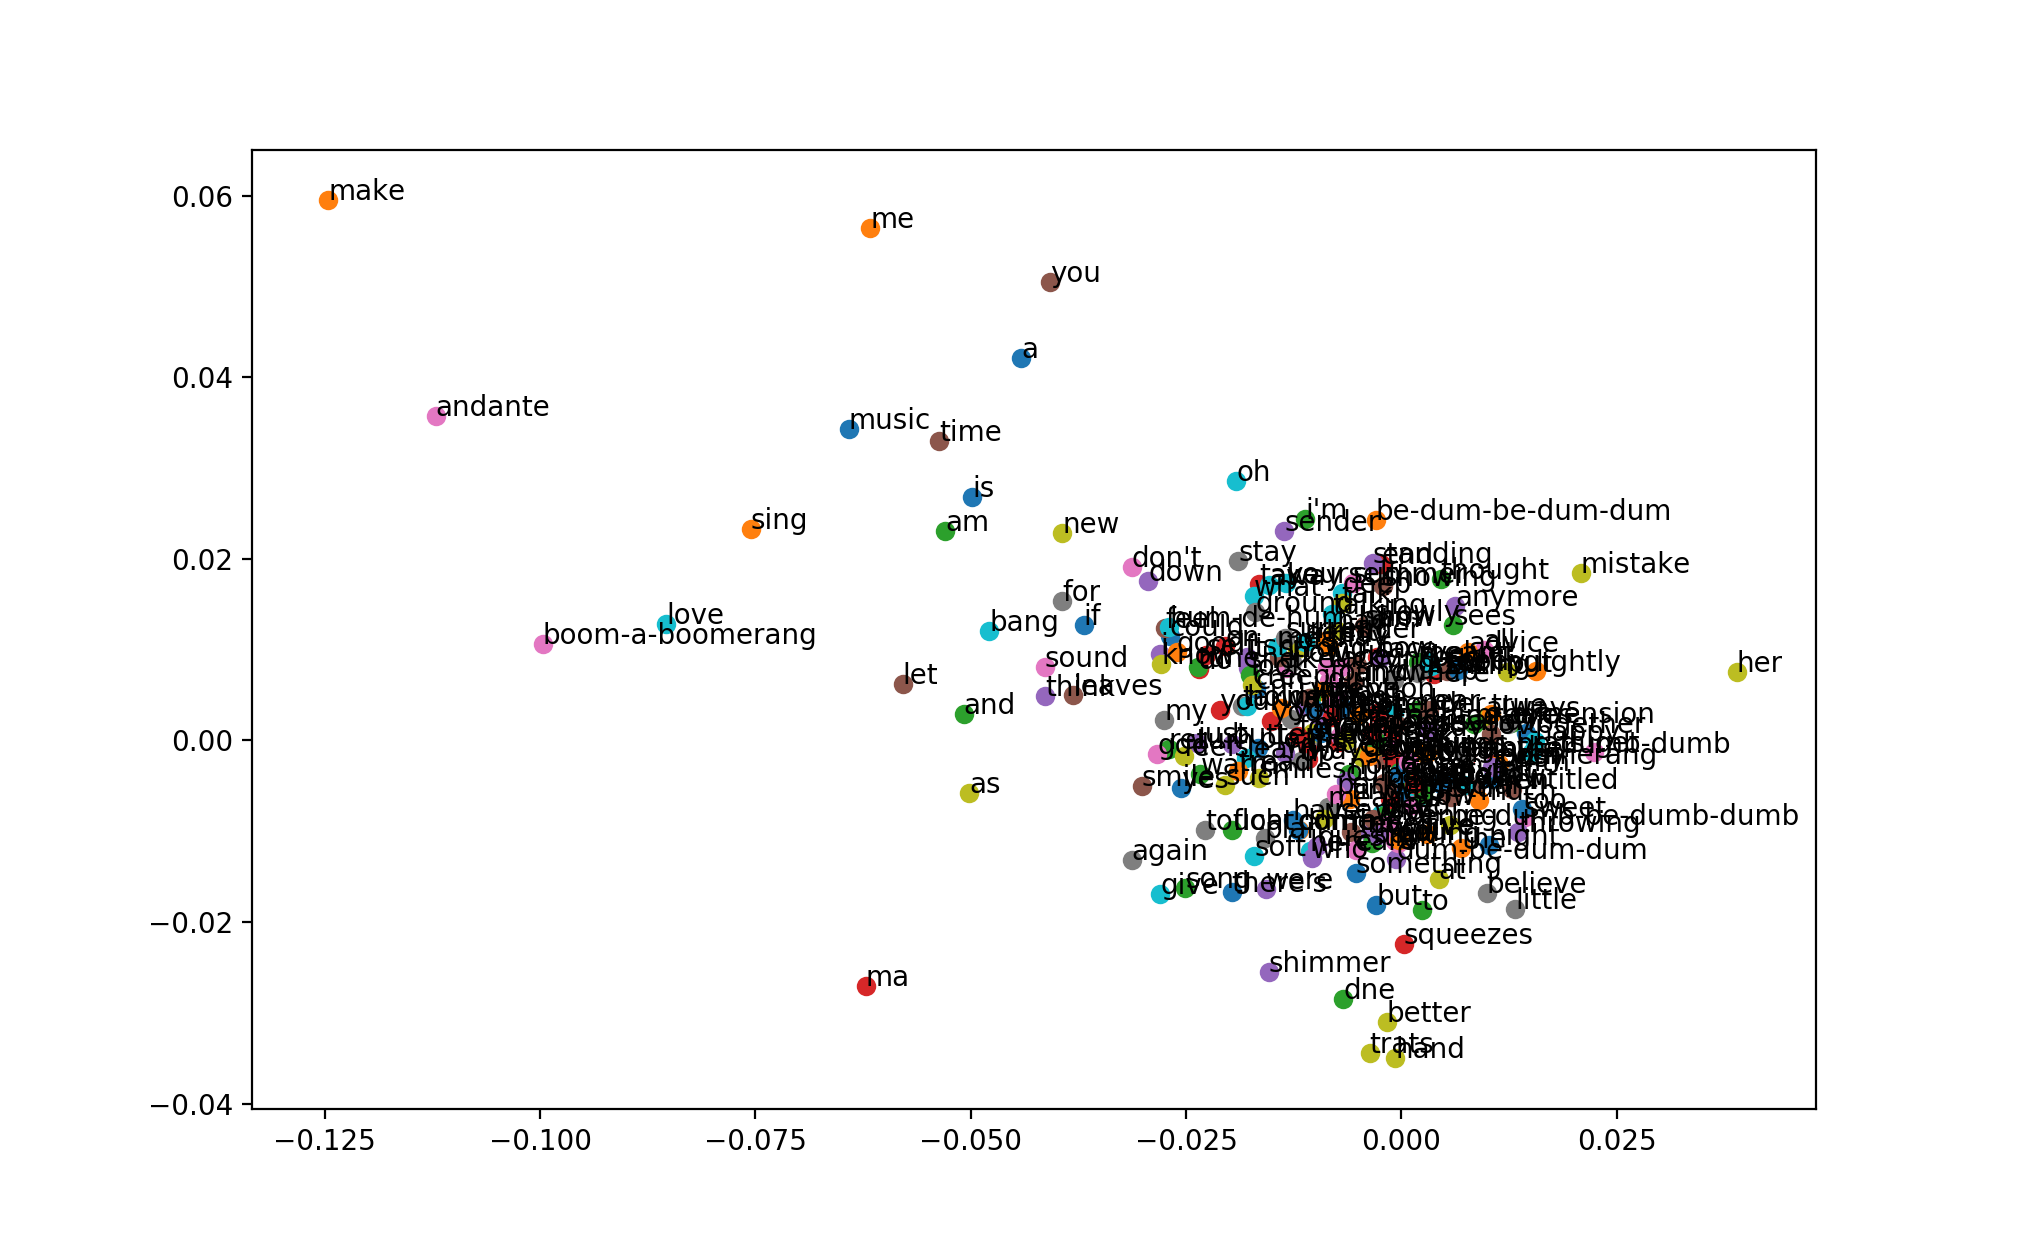

In [146]:
%matplotlib notebook
for i in range(W_h.shape[0]):
    plt.scatter(W_h[i,0],W_h[i,1])
    plt.annotate(id_to_word[i],[W_h[i,0],W_h[i,1]])